$$ma = -kx$$

$$m \frac{d^2 x}{d t^2} = -kx$$

$$\frac{d^2 x}{d t^2} + \omega^2 x = 0$$

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
class PINN(nn.Module):
    def __init__(self, hidden_size=64):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, t):
        return self.net(t)

def residual_loss(model, t, omega, gamma = 0.2):
    t.requires_grad_(True)
    x = model(t)
    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    ddx = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]
    res = ddx + 2 * gamma * dx + (omega ** 2) * x
    return torch.mean(res ** 2)

def initial_condition_loss(model, x0, v0):
    t0 = torch.tensor([[0.0]], requires_grad=True)
    x = model(t0)
    dx = torch.autograd.grad(x, t0, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    return (x - x0)**2 + (dx - v0)**2

In [34]:
model = PINN(hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Constants
omega = 1.0
x0 = torch.tensor([[1.0]])
v0 = torch.tensor([[0.0]])
T_MAX = 20
gamma = 0.2

# Training loop
for epoch in range(30000):
    t_epoch = torch.rand(100, 1) * T_MAX
    optimizer.zero_grad()

    loss_res = residual_loss(model, t_epoch, omega, gamma)
    loss_ic = initial_condition_loss(model, x0, v0)

    loss = loss_res * 10 + loss_ic

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.9357122778892517
Epoch 100, Loss: 0.09724707156419754
Epoch 200, Loss: 0.047668613493442535
Epoch 300, Loss: 0.04991556704044342
Epoch 400, Loss: 0.04324440285563469
Epoch 500, Loss: 0.04353012144565582
Epoch 600, Loss: 0.029980912804603577
Epoch 700, Loss: 0.03298095986247063
Epoch 800, Loss: 0.031106002628803253
Epoch 900, Loss: 0.040084972977638245
Epoch 1000, Loss: 0.03665895760059357
Epoch 1100, Loss: 0.08213002234697342
Epoch 1200, Loss: 0.02142898552119732
Epoch 1300, Loss: 0.02380228042602539
Epoch 1400, Loss: 0.033800654113292694
Epoch 1500, Loss: 0.027744725346565247
Epoch 1600, Loss: 0.022863371297717094
Epoch 1700, Loss: 0.026706580072641373
Epoch 1800, Loss: 0.02702486142516136
Epoch 1900, Loss: 0.02096652053296566
Epoch 2000, Loss: 0.021055083721876144
Epoch 2100, Loss: 0.022614305838942528
Epoch 2200, Loss: 0.015988199040293694
Epoch 2300, Loss: 0.030657315626740456
Epoch 2400, Loss: 0.01942400075495243
Epoch 2500, Loss: 0.03033353015780449
Epoch 2600, L

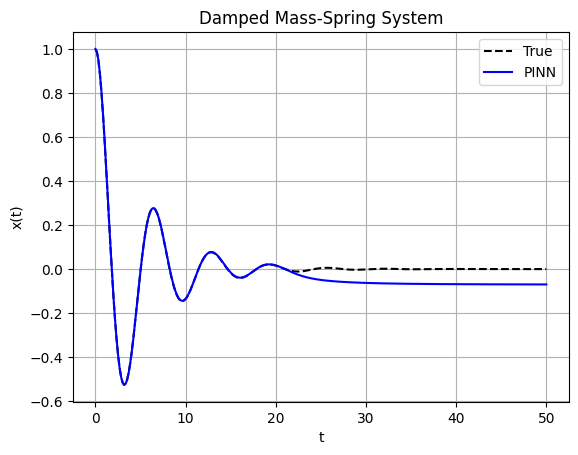

In [36]:
def plot_result(model, gamma, omega, x0, v0, T = 5.0):
    t_test = torch.linspace(0, T, 300).view(-1, 1)
    x_pred = model(t_test).detach().numpy()
    t_np = t_test.numpy()

    # True solution: underdamped case
    w_d = np.sqrt(omega**2 - gamma**2)
    A = x0.item()
    B = (v0.item() + gamma * A) / w_d
    x_true = np.exp(-gamma * t_np) * (A * np.cos(w_d * t_np) + B * np.sin(w_d * t_np))

    plt.plot(t_np, x_true, 'k--', label="True")
    plt.plot(t_np, x_pred, 'b-', label="PINN")
    plt.xlabel("t"), plt.ylabel("x(t)")
    plt.title("Damped Mass-Spring System")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_result(model, gamma=0.2, omega=1.0, x0=x0, v0=v0, T=50)